In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

def load_tourism_data():
    try:
        train_df = pd.read_csv(r'c:\Users\user\Downloads\college_stuff\data analytics\Train.csv')
        test_df = pd.read_csv(r'c:\Users\user\Downloads\college_stuff\data analytics\Test.csv')
        sample_submission = pd.read_csv(r'c:\Users\user\Downloads\college_stuff\data analytics\SampleSubmission.csv')
        print("Data loaded successfully!")
        print(f"Train data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        print(f"Sample submission shape: {sample_submission.shape}")
        return train_df, test_df, sample_submission
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return None, None, None

def explore_dataset(df, dataset_name="Dataset"):
    print(f"\n=== {dataset_name} Exploration ===")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    return df.describe()

Starting Tourism Data Analysis...
Data loaded successfully!
Train data shape: (4809, 23)
Test data shape: (1601, 22)
Sample submission shape: (1601, 2)

EXPLORING TRAINING DATA

=== Training Data Exploration ===
Shape: (4809, 23)

Columns: ['ID', 'country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing', 'total_cost']

Data Types:
ID                        object
country                   object
age_group                 object
travel_with               object
total_female             float64
total_male               float64
purpose                   object
main_activity             object
info_source               object
tour_arrangement          object
package_transport_in

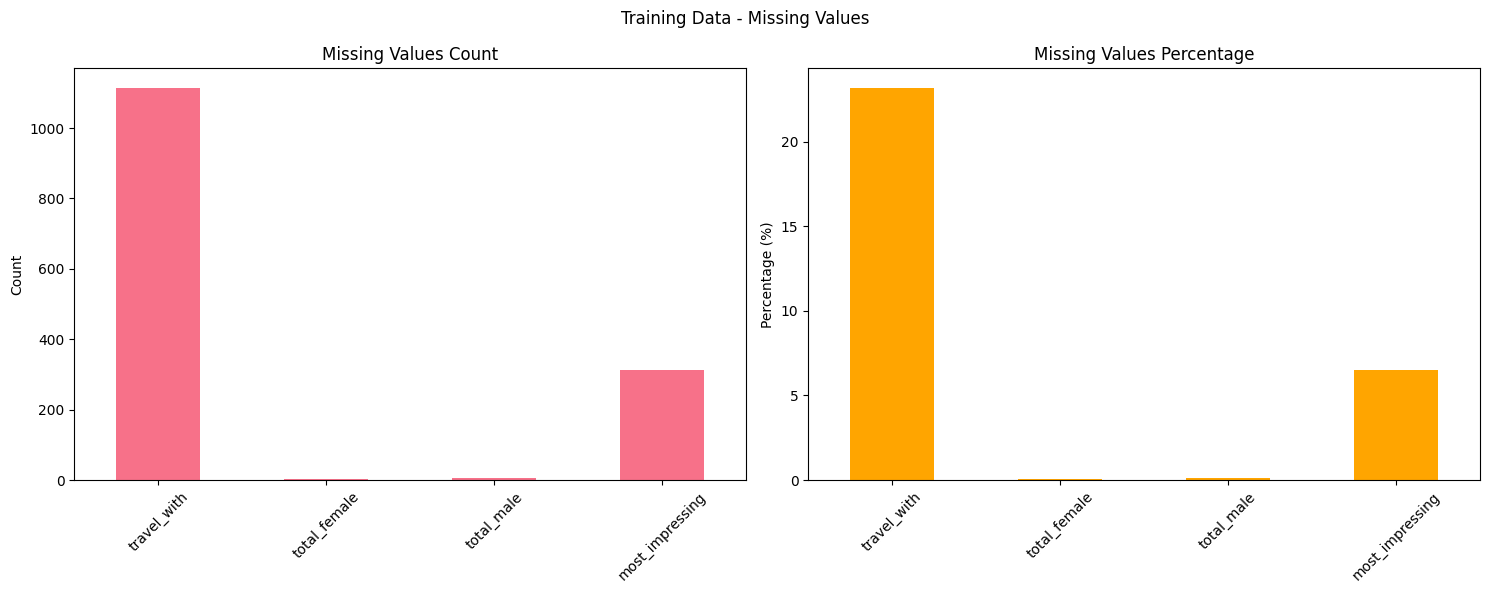


CLEANING DATA
=== Initial Data Info ===
Shape before cleaning: (4809, 23)
Missing values:
ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64
Removed 0 rows with missing total_cost
Filled missing values in travel_with with mode: Alone
Filled missing values in most_impressing with mode: Friendly People
Filled missing values in total_female with me

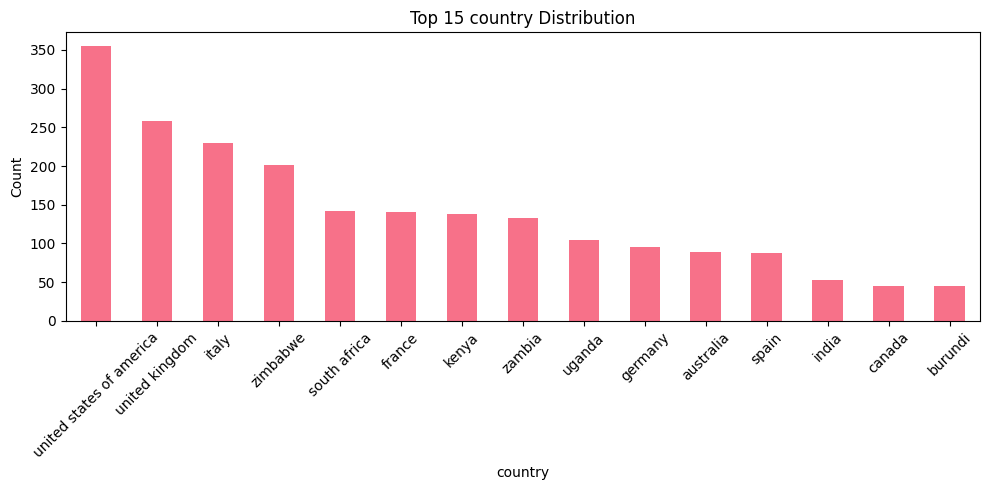

Grouped 69 rare country values into 'other'.

DATA VISUALIZATION
train clean data               ID                   country age_group        travel_with  \
0        tour_0                     other     45-64  friends/relatives   
3     tour_1002            united kingdom     25-44             spouse   
5     tour_1005            united kingdom     25-44              alone   
6     tour_1007              south africa     45-64              alone   
7     tour_1008  united states of america     45-64  friends/relatives   
...         ...                       ...       ...                ...   
4801   tour_989                     italy     45-64  friends/relatives   
4804   tour_993                     other     45-64              alone   
4805   tour_994  united states of america     25-44             spouse   
4807   tour_997              south africa     25-44  friends/relatives   
4808   tour_999            united kingdom     25-44             spouse   

      total_female  total_ma

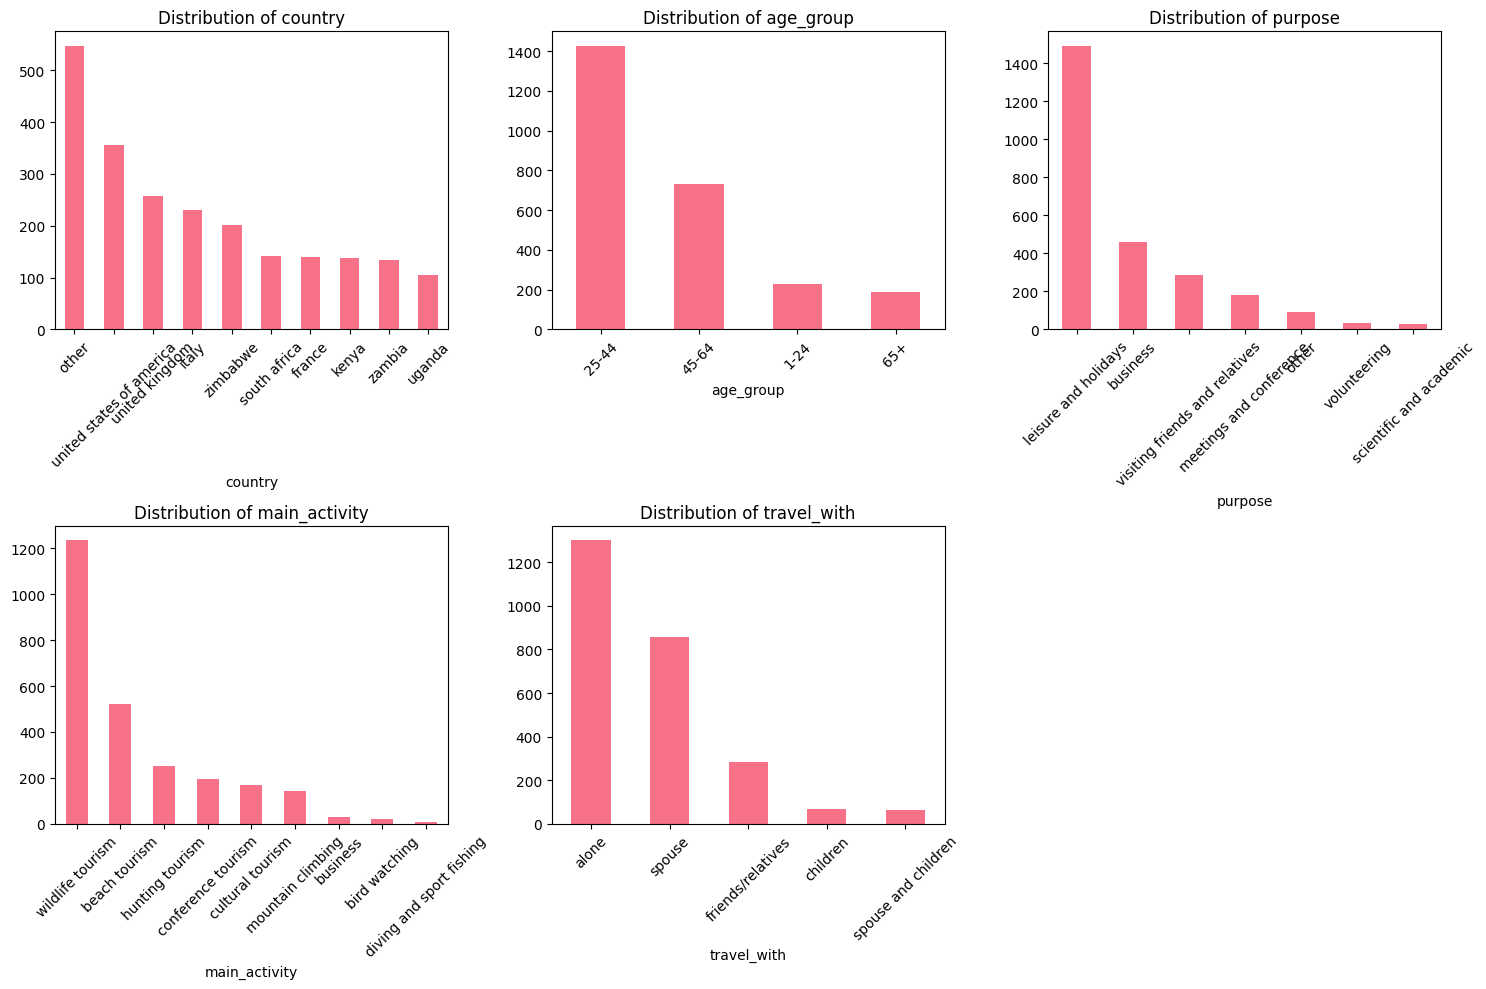

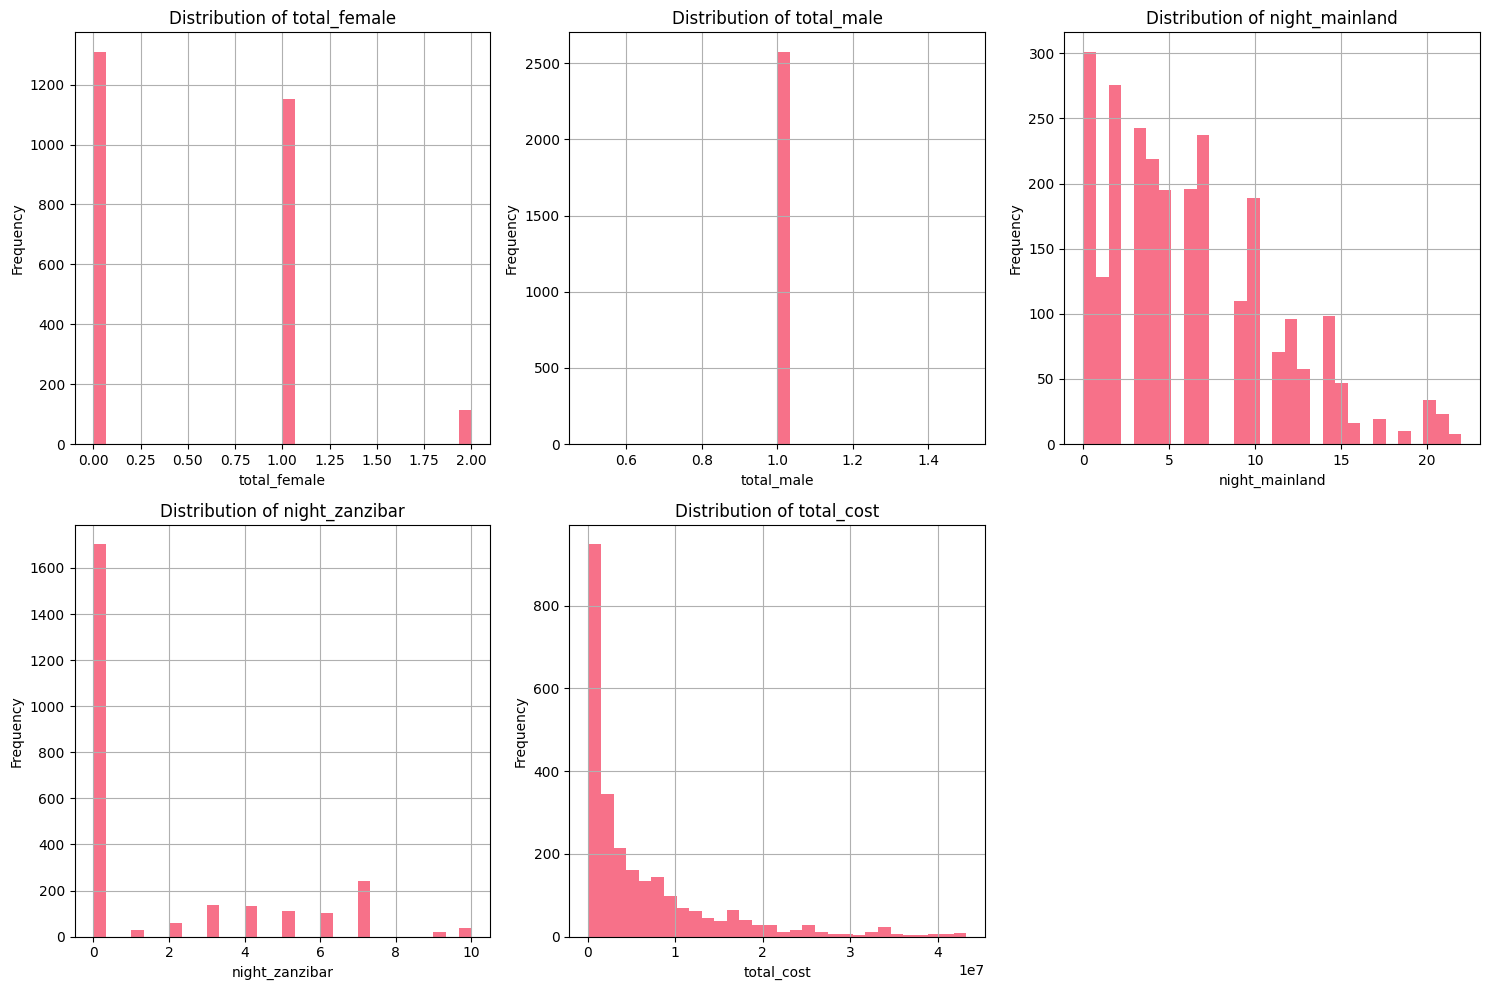

Creating interactive plots...



CORRELATION ANALYSIS


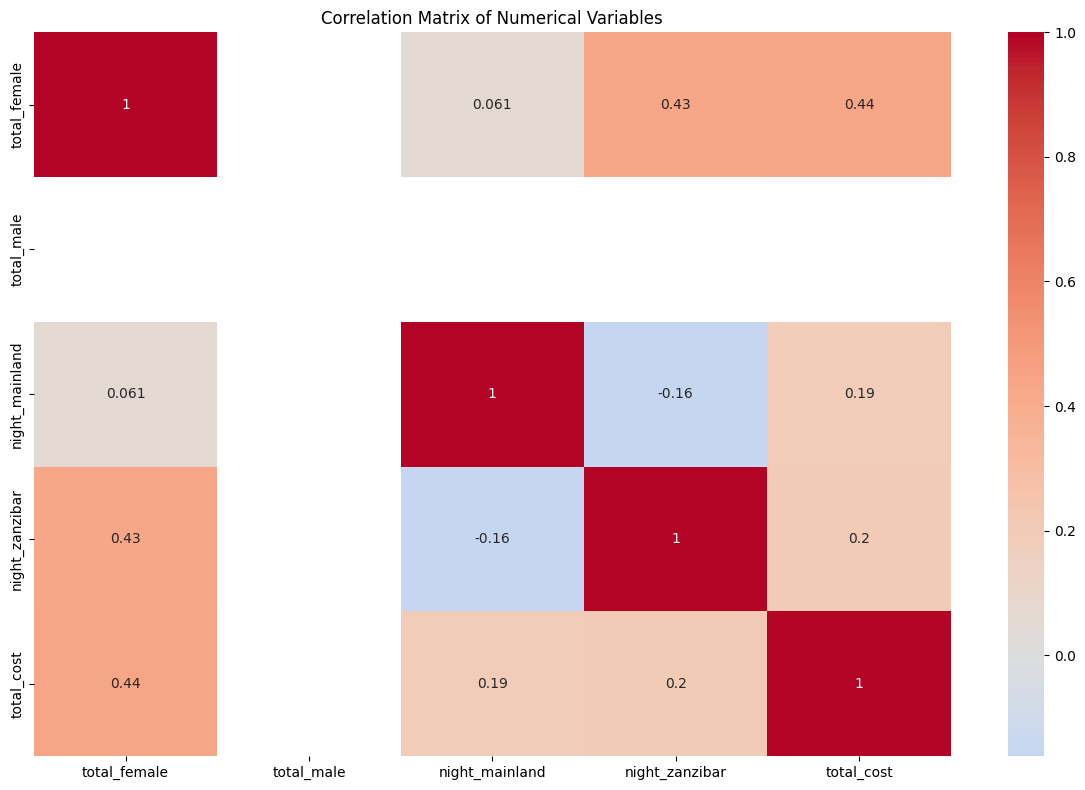


Analysis Complete!


In [20]:
def clean_tourism_data(df):
    df_clean = df.copy()
    print("=== Initial Data Info ===")
    print(f"Shape before cleaning: {df_clean.shape}")
    print(f"Missing values:\n{df_clean.isnull().sum()}")
    
    if 'total_cost' in df_clean.columns:
        initial_rows = len(df_clean)
        df_clean = df_clean.dropna(subset=['total_cost'])
        print(f"Removed {initial_rows - len(df_clean)} rows with missing total_cost")
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_value = df_clean[col].mode().iloc[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col].fillna(mode_value, inplace=True)
            print(f"Filled missing values in {col} with mode: {mode_value}")
    
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_clean[col].isnull().sum() > 0:
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            print(f"Filled missing values in {col} with median: {median_value}")
    
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {initial_rows - len(df_clean)} duplicate rows")
    print(f"\nShape after cleaning: {df_clean.shape}")
    return df_clean

def standardize_tourism_data(df):
    df_std = df.copy()
    text_columns = ['country', 'travel_with', 'purpose', 'main_activity', 
                   'infor_source', 'tour_arrangment', 'payment_mode', 'most_impressing']
    for col in text_columns:
        if col in df_std.columns:
            df_std[col] = df_std[col].astype(str).str.strip().str.lower()
    return df_std

def handle_outliers(df, method='iqr', columns=None):
    """Remove outliers using IQR or Z-score method"""
    df_clean = df.copy()
    
    if columns is None:
        columns = df_clean.select_dtypes(include=[np.number]).columns
        if 'total_cost' in columns:
            columns = [col for col in columns if col != 'total_cost']
    
    initial_rows = len(df_clean)
    
    for col in columns:
        if col in df_clean.columns:
            if method == 'iqr':
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            elif method == 'zscore':
                z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
                outliers = z_scores > 3
            
            df_clean = df_clean[~outliers]
    
    print(f"Removed {initial_rows - len(df_clean)} outlier rows using {method} method")
    return df_clean

def handle_target_outliers(df, target_col='total_cost', percentile_threshold=0.95):
    """Remove extreme outliers from target variable"""
    if target_col not in df.columns:
        return df
    
    threshold = df[target_col].quantile(percentile_threshold)
    initial_rows = len(df)
    df_clean = df[df[target_col] <= threshold].copy()
    
    print(f"Removed {initial_rows - len(df_clean)} extreme cost outliers above ${threshold:,.2f}")
    return df_clean

def plot_missing_values(df, title="Missing Values Analysis"):
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    missing_data[missing_data > 0].plot(kind='bar', ax=ax1)
    ax1.set_title('Missing Values Count')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    missing_percent[missing_percent > 0].plot(kind='bar', ax=ax2, color='orange')
    ax2.set_title('Missing Values Percentage')
    ax2.set_ylabel('Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_categorical_distribution(df, columns, max_categories=10):
    categorical_cols = [col for col in columns if col in df.columns]
    if not categorical_cols:
        print("No categorical columns found")
        return
    n_cols = min(3, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            value_counts = df[col].value_counts().head(max_categories)
            value_counts.plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
    for i in range(len(categorical_cols), len(axes)):
        axes[i].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_numerical_distribution(df, columns):
    numerical_cols = [col for col in columns if col in df.columns and df[col].dtype in ['int64', 'float64']]
    if not numerical_cols:
        print("No numerical columns found")
        return
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    plt.tight_layout()
    plt.show()

def create_interactive_plots(df):
    if 'country' in df.columns:
        country_counts = df['country'].value_counts().head(15)
        fig1 = px.bar(x=country_counts.values, y=country_counts.index, 
                     orientation='h', title='Top 15 Countries by Tourist Count')
        fig1.show()
    if 'age_group' in df.columns and 'total_cost' in df.columns:
        fig2 = px.box(df, x='age_group', y='total_cost', 
                     title='Total Cost Distribution by Age Group')
        fig2.show()
    if 'purpose' in df.columns:
        purpose_counts = df['purpose'].value_counts()
        fig3 = px.pie(values=purpose_counts.values, names=purpose_counts.index,
                     title='Purpose of Visit Distribution')
        fig3.show()

def correlation_analysis(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 1:
        correlation_matrix = df[numerical_cols].corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numerical Variables')
        plt.tight_layout()
        plt.show()
        return correlation_matrix
    else:
        print("Not enough numerical columns for correlation analysis")
        return None

def analyze_class_distribution(df, class_col='country', max_categories=15):
    """Print and plot the distribution of the target class (e.g., country)"""
    if class_col in df.columns:
        value_counts = df[class_col].value_counts().head(max_categories)
        print(f"Class distribution for '{class_col}':")
        print(value_counts)
        plt.figure(figsize=(10, 5))
        value_counts.plot(kind='bar')
        plt.title(f"Top {max_categories} {class_col} Distribution")
        plt.xlabel(class_col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{class_col}' not found in DataFrame.")

def handle_class_imbalance(df, method='country_grouping', class_col='country', min_count=50):
    """
    Handle class imbalance by grouping rare classes into 'other'.
    method: 'country_grouping' groups rare countries into 'other'.
    min_count: minimum count to keep a country as its own class.
    """
    df_balanced = df.copy()
    if method == 'country_grouping' and class_col in df_balanced.columns:
        value_counts = df_balanced[class_col].value_counts()
        rare_classes = value_counts[value_counts < min_count].index
        df_balanced[class_col] = df_balanced[class_col].apply(lambda x: 'other' if x in rare_classes else x)
        print(f"Grouped {len(rare_classes)} rare {class_col} values into 'other'.")
    else:
        print("No class imbalance handling applied.")
    return df_balanced

def run_complete_analysis():
    print("Starting Tourism Data Analysis...")
    train_df, test_df, sample_submission = load_tourism_data()
    if train_df is not None:
        print("\n" + "="*50)
        print("EXPLORING TRAINING DATA")
        print("="*50)
        train_summary = explore_dataset(train_df, "Training Data")
        plot_missing_values(train_df, "Training Data - Missing Values")
        
        print("\n" + "="*50)
        print("CLEANING DATA")
        print("="*50)
        train_clean = clean_tourism_data(train_df)
        train_clean = standardize_tourism_data(train_clean)
        
        print("\n" + "="*50)
        print("HANDLING OUTLIERS")
        print("="*50)
        # Remove outliers from features
        train_clean = handle_outliers(train_clean, method='iqr')
        # Remove extreme cost outliers
        train_clean = handle_target_outliers(train_clean, target_col='total_cost', percentile_threshold=0.98)
        
        print("\n" + "="*50)
        print("CLASS IMBALANCE ANALYSIS")
        print("="*50)
        analyze_class_distribution(train_clean)
        train_clean = handle_class_imbalance(train_clean, method='country_grouping')
        
        print("\n" + "="*50)
        print("DATA VISUALIZATION")
        print("="*50)
        print("train clean data " , train_clean)
        categorical_columns = ['country', 'age_group', 'purpose', 'main_activity', 'travel_with']
        plot_categorical_distribution(train_clean, categorical_columns)
        numerical_columns = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar', 'total_cost']
        plot_numerical_distribution(train_clean, numerical_columns)
        print("Creating interactive plots...")
        create_interactive_plots(train_clean)
        
        print("\n" + "="*50)
        print("CORRELATION ANALYSIS")
        print("="*50)
        correlation_matrix = correlation_analysis(train_clean)
        print("\nAnalysis Complete!")
        return train_clean, test_df, sample_submission
    else:
        print("Could not load data files. Please check file paths.")
        return None, None, None

train_clean, test_df, sample_submission = run_complete_analysis()

In [21]:
def feature_engineering(df):
    df_features = df.copy()
    df_features['total_tourists'] = df_features['total_female'] + df_features['total_male']
    df_features['total_nights'] = df_features['night_mainland'] + df_features['night_zanzibar']
    
    if 'total_cost' in df_features.columns:
        df_features['cost_per_night'] = df_features['total_cost'] / (df_features['total_nights'] + 1)
        df_features['cost_per_person'] = df_features['total_cost'] / (df_features['total_tourists'] + 1)
    
    package_cols = ['package_transport_int', 'package_accomodation', 'package_food', 
                   'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance']
    
    for col in package_cols:
        if col in df_features.columns:
            df_features[f'{col}_binary'] = (df_features[col].str.lower() == 'yes').astype(int)
    
    package_binary_cols = [f'{col}_binary' for col in package_cols if f'{col}_binary' in df_features.columns]
    df_features['total_packages'] = df_features[package_binary_cols].sum(axis=1)
    df_features['is_first_time'] = (df_features['first_trip_tz'].str.lower() == 'yes').astype(int)
    age_mapping = {'1-24': 1, '24-Jan': 1, '25-44': 2, '45-64': 3, '65+': 4}
    df_features['age_group_numeric'] = df_features['age_group'].map(age_mapping).fillna(2)
    
    purpose_mapping = {
        'leisure and holidays': 'leisure',
        'business': 'business', 
        'visiting friends and relatives': 'social',
        'meetings and conference': 'business'
    }
    df_features['purpose_category'] = df_features['purpose'].map(purpose_mapping).fillna('other')
    return df_features

def prepare_ml_data(df, target_column='total_cost'):
    df_ml = feature_engineering(df)
    
    # Use grouped country if available
    country_col = 'country_grouped' if 'country_grouped' in df_ml.columns else 'country'
    
    categorical_features = [country_col, 'travel_with', 'purpose_category', 'main_activity', 
                           'tour_arrangement', 'payment_mode']
    numerical_features = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar',
                         'age_group_numeric', 'total_tourists', 'total_nights', 'total_packages',
                         'is_first_time']
    package_binary_cols = [col for col in df_ml.columns if col.endswith('_binary')]
    numerical_features.extend(package_binary_cols)
    feature_df = pd.DataFrame()
    
    for feature in numerical_features:
        if feature in df_ml.columns:
            feature_df[feature] = df_ml[feature]
    
    for feature in categorical_features:
        if feature in df_ml.columns:
            dummies = pd.get_dummies(df_ml[feature], prefix=feature)
            feature_df = pd.concat([feature_df, dummies], axis=1)
    
    if target_column in df_ml.columns:
        y = df_ml[target_column]
        return feature_df, y, df_ml
    else:
        return feature_df, None, df_ml

print("Feature engineering functions created successfully!")

Feature engineering functions created successfully!


In [22]:
def train_supervised_models(X, y):
    print("=== Training Supervised Learning Models ===")
    
    # Handle class weights for imbalanced data
    from sklearn.utils.class_weight import compute_sample_weight
    
    # Create cost bins for sample weighting
    cost_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
    
    # Split data first, then calculate sample weights for training set only
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=cost_bins)
    
    # Calculate sample weights only for the training set
    train_cost_bins = pd.qcut(y_train, q=5, labels=False, duplicates='drop')
    train_sample_weights = compute_sample_weight('balanced', train_cost_bins)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            # Linear models don't support sample_weight in scikit-learn
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            # Tree-based models support sample_weight
            model.fit(X_train, y_train, sample_weight=train_sample_weights)
            y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'RMSE': rmse,
            'R2': r2,
            'MSE': mse
        }
        trained_models[name] = model
        print(f"RMSE: {rmse:.2f}")
        print(f"R2 Score: {r2:.4f}")
    
    plot_model_comparison(results)
    return trained_models, scaler, results

def plot_model_comparison(results):
    models = list(results.keys())
    r2_scores = [results[model]['R2'] for model in models]
    rmse_scores = [results[model]['RMSE'] for model in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.bar(models, r2_scores, color='skyblue')
    ax1.set_title('Model R² Scores')
    ax1.set_ylabel('R² Score')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(models, rmse_scores, color='lightcoral')
    ax2.set_title('Model RMSE Scores')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

print("Supervised learning functions created successfully!")

Supervised learning functions created successfully!


In [23]:
def perform_customer_segmentation(df, n_clusters=5):
    print("=== Performing Customer Segmentation ===")
    clustering_features = ['total_tourists', 'total_nights', 'total_packages', 
                          'age_group_numeric', 'is_first_time']
    
    if 'total_cost' in df.columns:
        clustering_features.extend(['total_cost', 'cost_per_night', 'cost_per_person'])
    
    X_cluster = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    inertias = []
    silhouette_scores = []
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(K_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    
    ax2.plot(K_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    plt.tight_layout()
    plt.show()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    print(f"\nCluster Analysis:")
    for i in range(n_clusters):
        cluster_data = df_clustered[df_clustered['cluster'] == i]
        print(f"\nCluster {i} ({len(cluster_data)} customers):")
        print(f"  Average total cost: ${cluster_data['total_cost'].mean():,.2f}")
        print(f"  Average nights: {cluster_data['total_nights'].mean():.1f}")
        print(f"  Average tourists: {cluster_data['total_tourists'].mean():.1f}")
        print(f"  Most common purpose: {cluster_data['purpose'].mode().iloc[0] if len(cluster_data) > 0 else 'N/A'}")
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Customer Segments (PCA Visualization)')
    plt.colorbar(scatter)
    plt.show()
    return df_clustered, kmeans, scaler

print("Customer segmentation functions created successfully!")

Customer segmentation functions created successfully!


In [24]:
def build_recommendation_system(df_clustered):
    print("=== Building Recommendation System ===")
    recommendation_features = ['cluster', 'total_tourists', 'total_nights', 'total_packages',
                              'age_group_numeric', 'is_first_time']
    
    if 'total_cost' in df_clustered.columns:
        recommendation_features.append('cost_per_person')
    
    X_rec = df_clustered[recommendation_features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_rec)
    nn_model = NearestNeighbors(n_neighbors=10, metric='cosine')
    nn_model.fit(X_scaled)
    
    def get_recommendations(customer_index, n_recommendations=5):
        distances, indices = nn_model.kneighbors([X_scaled[customer_index]], 
                                                n_neighbors=n_recommendations+1)
        similar_indices = indices[0][1:]
        similar_customers = df_clustered.iloc[similar_indices]
        customer = df_clustered.iloc[customer_index]
        
        print(f"\nRecommendations for Customer {customer['ID']}:")
        print(f"Customer Profile:")
        print(f"  Country: {customer['country']}")
        print(f"  Purpose: {customer['purpose']}")
        print(f"  Main Activity: {customer['main_activity']}")
        print(f"  Cluster: {customer['cluster']}")
        
        popular_activities = similar_customers['main_activity'].mode()
        popular_purposes = similar_customers['purpose'].mode()
        popular_countries = similar_customers['country'].mode()
        
        print(f"\nBased on similar customers, we recommend:")
        print(f"  Popular activities: {', '.join(popular_activities.head(3).tolist())}")
        print(f"  Popular purposes: {', '.join(popular_purposes.head(2).tolist())}")
        print(f"  Popular destinations: {', '.join(popular_countries.head(3).tolist())}")
        return similar_customers
    
    print("\nCluster-based Activity Recommendations:")
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        top_activities = cluster_data['main_activity'].value_counts().head(3)
        print(f"\nCluster {cluster_id} customers prefer:")
        for activity, count in top_activities.items():
            percentage = (count / len(cluster_data)) * 100
            print(f"  {activity}: {percentage:.1f}%")
    
    return nn_model, scaler, get_recommendations

def create_cost_prediction_tool(trained_models, scaler, feature_columns):
    def predict_cost(customer_features, model_name='Random Forest'):
        model = trained_models[model_name]
        feature_vector = np.array(customer_features).reshape(1, -1)
        if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            feature_vector = scaler.transform(feature_vector)
        predicted_cost = model.predict(feature_vector)[0]
        return predicted_cost
    return predict_cost

print("Recommendation system functions created successfully!")

Recommendation system functions created successfully!


Starting Complete Machine Learning Analysis...

FEATURE ENGINEERING
Created 54 features for 2574 samples
Feature columns: ['total_female', 'total_male', 'night_mainland', 'night_zanzibar', 'age_group_numeric', 'total_tourists', 'total_nights', 'total_packages', 'is_first_time', 'package_transport_int_binary', 'package_accomodation_binary', 'package_food_binary', 'package_transport_tz_binary', 'package_sightseeing_binary', 'package_guided_tour_binary', 'package_insurance_binary', 'country_australia', 'country_france', 'country_germany', 'country_india', 'country_italy', 'country_kenya', 'country_other', 'country_south africa', 'country_spain', 'country_uganda', 'country_united kingdom', 'country_united states of america', 'country_zambia', 'country_zimbabwe', 'travel_with_alone', 'travel_with_children', 'travel_with_friends/relatives', 'travel_with_spouse', 'travel_with_spouse and children', 'purpose_category_business', 'purpose_category_leisure', 'purpose_category_other', 'purpose_cate

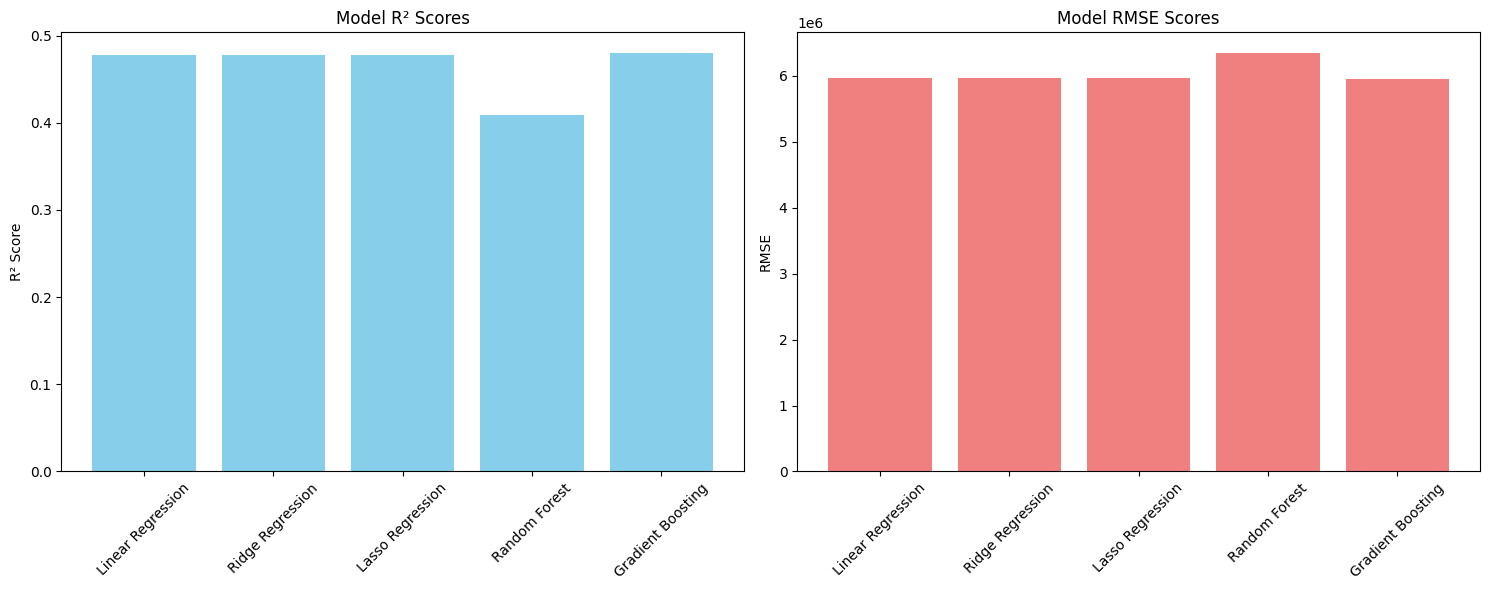


UNSUPERVISED LEARNING - CUSTOMER SEGMENTATION
=== Performing Customer Segmentation ===


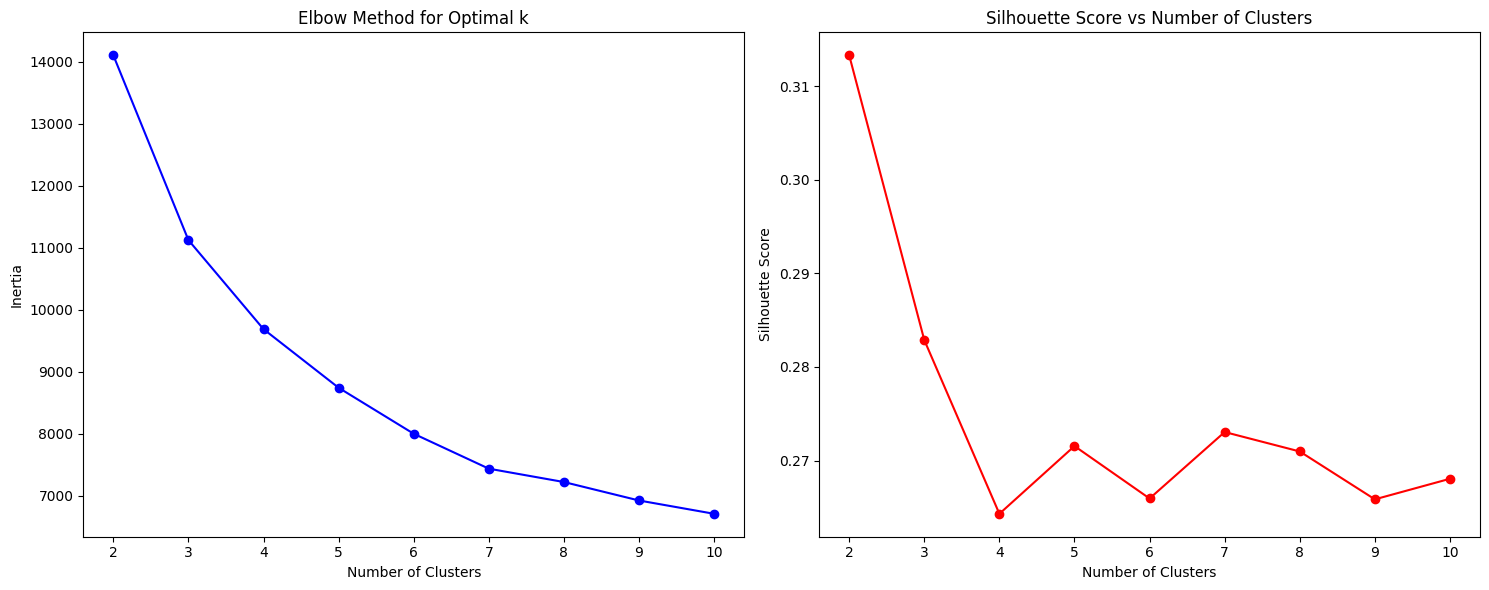


Cluster Analysis:

Cluster 0 (754 customers):
  Average total cost: $1,305,282.94
  Average nights: 4.8
  Average tourists: 1.2
  Most common purpose: business

Cluster 1 (726 customers):
  Average total cost: $9,388,780.65
  Average nights: 9.0
  Average tourists: 1.9
  Most common purpose: leisure and holidays

Cluster 2 (539 customers):
  Average total cost: $1,707,462.01
  Average nights: 4.9
  Average tourists: 1.3
  Most common purpose: leisure and holidays

Cluster 3 (345 customers):
  Average total cost: $4,822,440.79
  Average nights: 16.5
  Average tourists: 1.6
  Most common purpose: leisure and holidays

Cluster 4 (210 customers):
  Average total cost: $27,255,378.10
  Average nights: 9.1
  Average tourists: 2.0
  Most common purpose: leisure and holidays


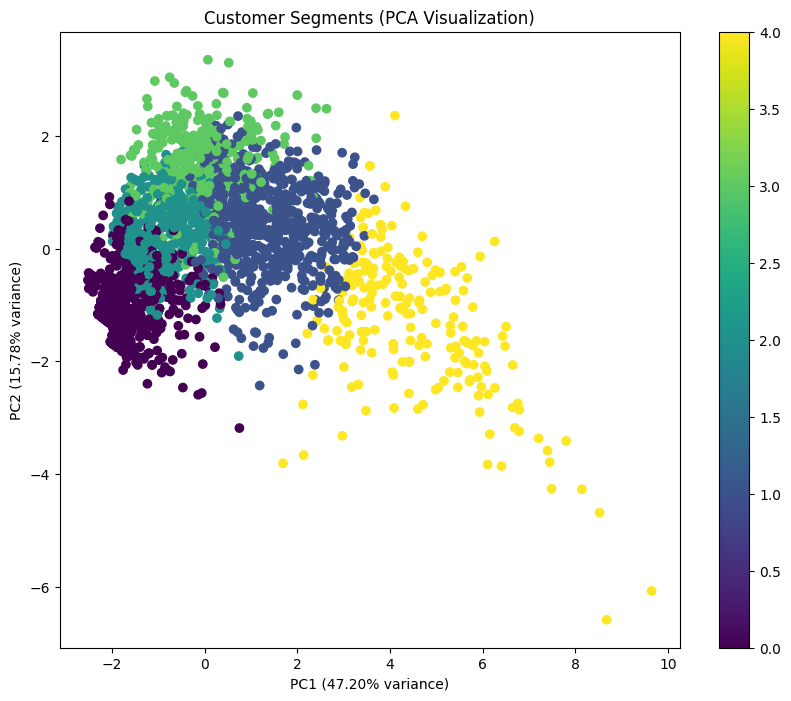


RECOMMENDATION SYSTEM
=== Building Recommendation System ===

Cluster-based Activity Recommendations:

Cluster 0 customers prefer:
  wildlife tourism: 39.7%
  hunting tourism: 19.4%
  beach tourism: 17.6%

Cluster 1 customers prefer:
  wildlife tourism: 57.0%
  beach tourism: 25.9%
  conference tourism: 9.8%

Cluster 2 customers prefer:
  wildlife tourism: 34.5%
  beach tourism: 22.8%
  hunting tourism: 13.9%

Cluster 3 customers prefer:
  wildlife tourism: 48.1%
  beach tourism: 17.1%
  conference tourism: 15.9%

Cluster 4 customers prefer:
  wildlife tourism: 81.4%
  beach tourism: 8.6%
  conference tourism: 6.2%

--- Example Recommendations ---

Recommendations for Customer tour_0:
Customer Profile:
  Country: other
  Purpose: leisure and holidays
  Main Activity: wildlife tourism
  Cluster: 0

Based on similar customers, we recommend:
  Popular activities: cultural tourism
  Popular purposes: leisure and holidays
  Popular destinations: other

Recommendations for Customer tour_102

In [25]:
def run_complete_ml_analysis():
    print("Starting Complete Machine Learning Analysis...")
    if 'train_clean' in globals() and train_clean is not None:
        print("\n" + "="*60)
        print("FEATURE ENGINEERING")
        print("="*60)
        X, y, df_engineered = prepare_ml_data(train_clean)
        print(f"Created {X.shape[1]} features for {X.shape[0]} samples")
        print(f"Feature columns: {list(X.columns)}")
        
        print("\n" + "="*60)
        print("SUPERVISED LEARNING - COST PREDICTION")
        print("="*60)
        trained_models, feature_scaler, model_results = train_supervised_models(X, y)
        predict_cost = create_cost_prediction_tool(trained_models, feature_scaler, X.columns)
        
        print("\n" + "="*60)
        print("UNSUPERVISED LEARNING - CUSTOMER SEGMENTATION")
        print("="*60)
        # Use df_engineered for clustering, not undefined df_clustered
        df_clustered, cluster_model, cluster_scaler = perform_customer_segmentation(df_engineered)
        
        print("\n" + "="*60)
        print("RECOMMENDATION SYSTEM")
        print("="*60)
        nn_model, rec_scaler, get_recommendations = build_recommendation_system(df_clustered)
        
        print("\n--- Example Recommendations ---")
        sample_customers = [0, 10, 50, 100]
        for idx in sample_customers:
            if 0 <= idx < len(df_clustered):
                get_recommendations(idx, n_recommendations=3)
            else:
                print(f"Index {idx} is out of bounds for df_clustered (size={len(df_clustered)})")
        
        print("\nComplete ML Analysis Finished!")
        return {
            'feature_data': df_engineered,
            'clustered_data': df_clustered,
            'supervised_models': trained_models,
            'cluster_model': cluster_model,
            'recommendation_model': nn_model,
            'predict_cost': predict_cost,
            'get_recommendations': get_recommendations,
            'model_results': model_results
        }
    else:
        print("No cleaned training data available. Please run data cleaning first.")
        return None

ml_results = run_complete_ml_analysis()

In [26]:
def interactive_prediction_demo():
    if ml_results is None:
        print("Please run the ML analysis first!")
        return
    
    print("Interactive Tourism Cost Prediction & Recommendation Demo")
    print("="*60)
    
    scenarios = {
        'Business Traveler': {
            'description': 'Solo business traveler from Germany, 25-44 age group',
            'features': [0, 1, 5, 0, 2, 1, 5, 0, 1]
        },
        'Family Vacation': {
            'description': 'Family of 4 from UK for leisure, 45-64 age group',
            'features': [2, 2, 10, 5, 3, 4, 15, 5, 0]
        },
        'Wildlife Enthusiast': {
            'description': 'Wildlife tourism enthusiast from USA, first time visitor',
            'features': [1, 1, 7, 3, 2, 2, 10, 3, 1]
        }
    }
    
    print("\nSample Predictions:")
    for scenario_name, scenario_data in scenarios.items():
        print(f"\n{scenario_name}:")
        print(f"  {scenario_data['description']}")
        try:
            predicted_cost = ml_results['predict_cost'](scenario_data['features'], 'Random Forest')
            print(f"  Predicted Cost: ${predicted_cost:,.2f}")
        except Exception as e:
            print(f"  Prediction Error: {e}")
    
    print(f"\nCustomer Segmentation Summary:")
    clustered_data = ml_results['clustered_data']
    
    for cluster_id in sorted(clustered_data['cluster'].unique()):
        cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
        avg_cost = cluster_data['total_cost'].mean()
        most_common_activity = cluster_data['main_activity'].mode().iloc[0]
        print(f"  Cluster {cluster_id}: {len(cluster_data)} customers")
        print(f"    Average Cost: ${avg_cost:,.2f}")
        print(f"    Most Popular Activity: {most_common_activity}")
    
    print(f"\nModel Performance Summary:")
    for model_name, metrics in ml_results['model_results'].items():
        print(f"  {model_name}: R² = {metrics['R2']:.4f}, RMSE = ${metrics['RMSE']:,.2f}")

interactive_prediction_demo()

Interactive Tourism Cost Prediction & Recommendation Demo

Sample Predictions:

Business Traveler:
  Solo business traveler from Germany, 25-44 age group
  Prediction Error: X has 9 features, but RandomForestRegressor is expecting 54 features as input.

Family Vacation:
  Family of 4 from UK for leisure, 45-64 age group
  Prediction Error: X has 9 features, but RandomForestRegressor is expecting 54 features as input.

Wildlife Enthusiast:
  Wildlife tourism enthusiast from USA, first time visitor
  Prediction Error: X has 9 features, but RandomForestRegressor is expecting 54 features as input.

Customer Segmentation Summary:
  Cluster 0: 754 customers
    Average Cost: $1,305,282.94
    Most Popular Activity: wildlife tourism
  Cluster 1: 726 customers
    Average Cost: $9,388,780.65
    Most Popular Activity: wildlife tourism
  Cluster 2: 539 customers
    Average Cost: $1,707,462.01
    Most Popular Activity: wildlife tourism
  Cluster 3: 345 customers
    Average Cost: $4,822,440.79

In [27]:
def prepare_test_data_for_prediction(test_df, train_feature_columns):
    print("=== Preparing Test Data for Prediction ===")
    test_clean = test_df.copy()
    
    categorical_cols = test_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if test_clean[col].isnull().sum() > 0:
            mode_value = test_clean[col].mode().iloc[0] if len(test_clean[col].mode()) > 0 else 'Unknown'
            test_clean[col].fillna(mode_value, inplace=True)
            print(f"Filled missing values in {col} with mode: {mode_value}")
    
    numerical_cols = test_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if test_clean[col].isnull().sum() > 0:
            median_value = test_clean[col].median()
            test_clean[col].fillna(median_value, inplace=True)
            print(f"Filled missing values in {col} with median: {median_value}")
    
    text_columns = ['country', 'travel_with', 'purpose', 'main_activity', 
                   'info_source', 'tour_arrangment', 'payment_mode', 'most_impressing']
    
    for col in text_columns:
        if col in test_clean.columns:
            test_clean[col] = test_clean[col].astype(str).str.strip().str.lower()
    
    # Apply same country grouping as training data
    if 'train_clean' in globals() and 'country_grouped' in train_clean.columns:
        country_counts = train_clean['country'].value_counts()
        low_freq_countries = country_counts[country_counts < 10].index
        test_clean['country_grouped'] = test_clean['country'].copy()
        test_clean.loc[test_clean['country'].isin(low_freq_countries), 'country_grouped'] = 'other_countries'
        print("Applied country grouping to test data")
    
    test_engineered = feature_engineering(test_clean)
    X_test, _, _ = prepare_ml_data(test_engineered, target_column=None)
    
    for col in train_feature_columns:
        if col not in X_test.columns:
            X_test[col] = 0
            print(f"Added missing column: {col}")
    
    X_test = X_test[train_feature_columns]
    print(f"Test data prepared: {X_test.shape[0]} samples with {X_test.shape[1]} features")
    print(f"Feature alignment check: {len(train_feature_columns)} training features = {X_test.shape[1]} test features")
    return X_test, test_engineered

def predict_test_costs_final(ml_results, test_df, model_name='Random Forest'):
    print(f"GENERATING FINAL TEST PREDICTIONS")
    print("="*60)
    print(f"Using model: {model_name}")
    print(f"Test dataset shape: {test_df.shape}")
    
    train_feature_data = ml_results['feature_data']
    X_train, _, _ = prepare_ml_data(train_feature_data)
    train_feature_columns = X_train.columns.tolist()
    print(f"Training features: {len(train_feature_columns)}")
    
    X_test, test_engineered = prepare_test_data_for_prediction(test_df, train_feature_columns)
    trained_model = ml_results['supervised_models'][model_name]
    print(f"\nMaking predictions with {model_name}...")
    
    predicted_costs = trained_model.predict(X_test)
    predicted_costs = np.maximum(predicted_costs, 0)
    
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'total_cost': predicted_costs.round(2)
    })
    
    print(f"\nPREDICTION SUMMARY:")
    print(f"Number of predictions: {len(predicted_costs)}")
    print(f"Average predicted cost: ${np.mean(predicted_costs):,.2f}")
    print(f"Median predicted cost: ${np.median(predicted_costs):,.2f}")
    print(f"Min predicted cost: ${np.min(predicted_costs):,.2f}")
    print(f"Max predicted cost: ${np.max(predicted_costs):,.2f}")
    print(f"Standard deviation: ${np.std(predicted_costs):,.2f}")
    
    return submission_df, test_engineered

def save_final_submission(submission_df, filename='final_tourism_predictions.csv'):
    filepath = f'c:\\Users\\user\\Downloads\\college_stuff\\data analytics\\{filename}'
    final_submission = submission_df.copy()
    final_submission.to_csv(filepath, index=False)
    
    print(f"\nSUBMISSION FILE SAVED")
    print(f"Location: {filepath}")
    print(f"Records: {len(final_submission)}")
    
    print(f"\nFIRST 10 PREDICTIONS:")
    display_df = final_submission.head(10).copy()
    display_df['total_cost'] = display_df['total_cost'].apply(lambda x: f"${x:,.2f}")
    print(display_df.to_string(index=False))
    
    print(f"\nLAST 10 PREDICTIONS:")
    display_df = final_submission.tail(10).copy()
    display_df['total_cost'] = display_df['total_cost'].apply(lambda x: f"${x:,.2f}")
    print(display_df.to_string(index=False))
    return filepath

def display_predictions_table(submission_df, num_rows=20):
    print(f"\nCOMPLETE PREDICTIONS TABLE")
    print("="*60)
    
    display_df = submission_df.copy()
    display_df['Predicted Cost'] = display_df['total_cost'].apply(lambda x: f"${x:,.2f}")
    display_df = display_df.rename(columns={'ID': 'Tour ID'})
    display_df = display_df[['Tour ID', 'Predicted Cost']]
    
    print(f"Total Tours: {len(submission_df)}")
    print(f"Average Cost: ${submission_df['total_cost'].mean():,.2f}")
    print(f"Median Cost: ${submission_df['total_cost'].median():,.2f}")
    print(f"Cost Range: ${submission_df['total_cost'].min():,.2f} - ${submission_df['total_cost'].max():,.2f}")
    
    print(f"\nFIRST {num_rows} PREDICTIONS:")
    print(display_df.head(num_rows).to_string(index=False))
    
    if len(submission_df) > num_rows * 2:
        print(f"\n... (showing first {num_rows} and last {num_rows} of {len(submission_df)} total predictions)")
        print(f"\nLAST {num_rows} PREDICTIONS:")
        print(display_df.tail(num_rows).to_string(index=False))
    
    print(f"\nCOST DISTRIBUTION SUMMARY:")
    cost_ranges = [
        (0, 1000000, "Under $1M"),
        (1000000, 5000000, "$1M - $5M"),
        (5000000, 10000000, "$5M - $10M"),
        (10000000, float('inf'), "Over $10M")
    ]
    
    for min_cost, max_cost, label in cost_ranges:
        if max_cost == float('inf'):
            count = len(submission_df[submission_df['total_cost'] >= min_cost])
        else:
            count = len(submission_df[(submission_df['total_cost'] >= min_cost) & 
                                     (submission_df['total_cost'] < max_cost)])
        percentage = (count / len(submission_df)) * 100
        print(f"  {label:<15}: {count:>4d} tours ({percentage:>5.1f}%)")

print("Final test prediction functions ready!")

Final test prediction functions ready!


In [28]:
def perform_customer_segmentation(df, n_clusters=5):
    print("=== Performing Customer Segmentation ===")
    clustering_features = ['total_tourists', 'total_nights', 'total_packages', 
                          'age_group_numeric', 'is_first_time']
    
    if 'total_cost' in df.columns:
        clustering_features.extend(['total_cost', 'cost_per_night', 'cost_per_person'])
    
    X_cluster = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    inertias = []
    silhouette_scores = []
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(K_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    
    ax2.plot(K_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    plt.tight_layout()
    plt.show()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    print(f"\nCluster Analysis:")
    for i in range(n_clusters):
        cluster_data = df_clustered[df_clustered['cluster'] == i]
        print(f"\nCluster {i} ({len(cluster_data)} customers):")
        print(f"  Average total cost: ${cluster_data['total_cost'].mean():,.2f}")
        print(f"  Average nights: {cluster_data['total_nights'].mean():.1f}")
        print(f"  Average tourists: {cluster_data['total_tourists'].mean():.1f}")
        print(f"  Most common purpose: {cluster_data['purpose'].mode().iloc[0] if len(cluster_data) > 0 else 'N/A'}")
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Customer Segments (PCA Visualization)')
    plt.colorbar(scatter)
    plt.show()
    return df_clustered, kmeans, scaler

print("Customer segmentation functions created successfully!")

Customer segmentation functions created successfully!


TOURISM COST PREDICTION COMPETITION
Generating predictions for Tanzania tourism expenditure dataset
Training data: 2574 samples
Test data: 1601 samples to predict
Trained models available: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting']

MODEL PERFORMANCE COMPARISON:
     Linear Regression: R² = 0.4773, RMSE = $5,963,222.50
     Ridge Regression: R² = 0.4773, RMSE = $5,962,969.38
     Lasso Regression: R² = 0.4773, RMSE = $5,963,221.36
     Random Forest: R² = 0.4089, RMSE = $6,341,293.45
BEST Gradient Boosting: R² = 0.4798, RMSE = $5,948,895.65

Selected model: Gradient Boosting
GENERATING FINAL TEST PREDICTIONS
Using model: Gradient Boosting
Test dataset shape: (1601, 22)
Training features: 54
=== Preparing Test Data for Prediction ===
Filled missing values in travel_with with mode: Alone
Filled missing values in most_impressing with mode: Friendly People
Filled missing values in total_female with median: 1.0
Filled missing values i

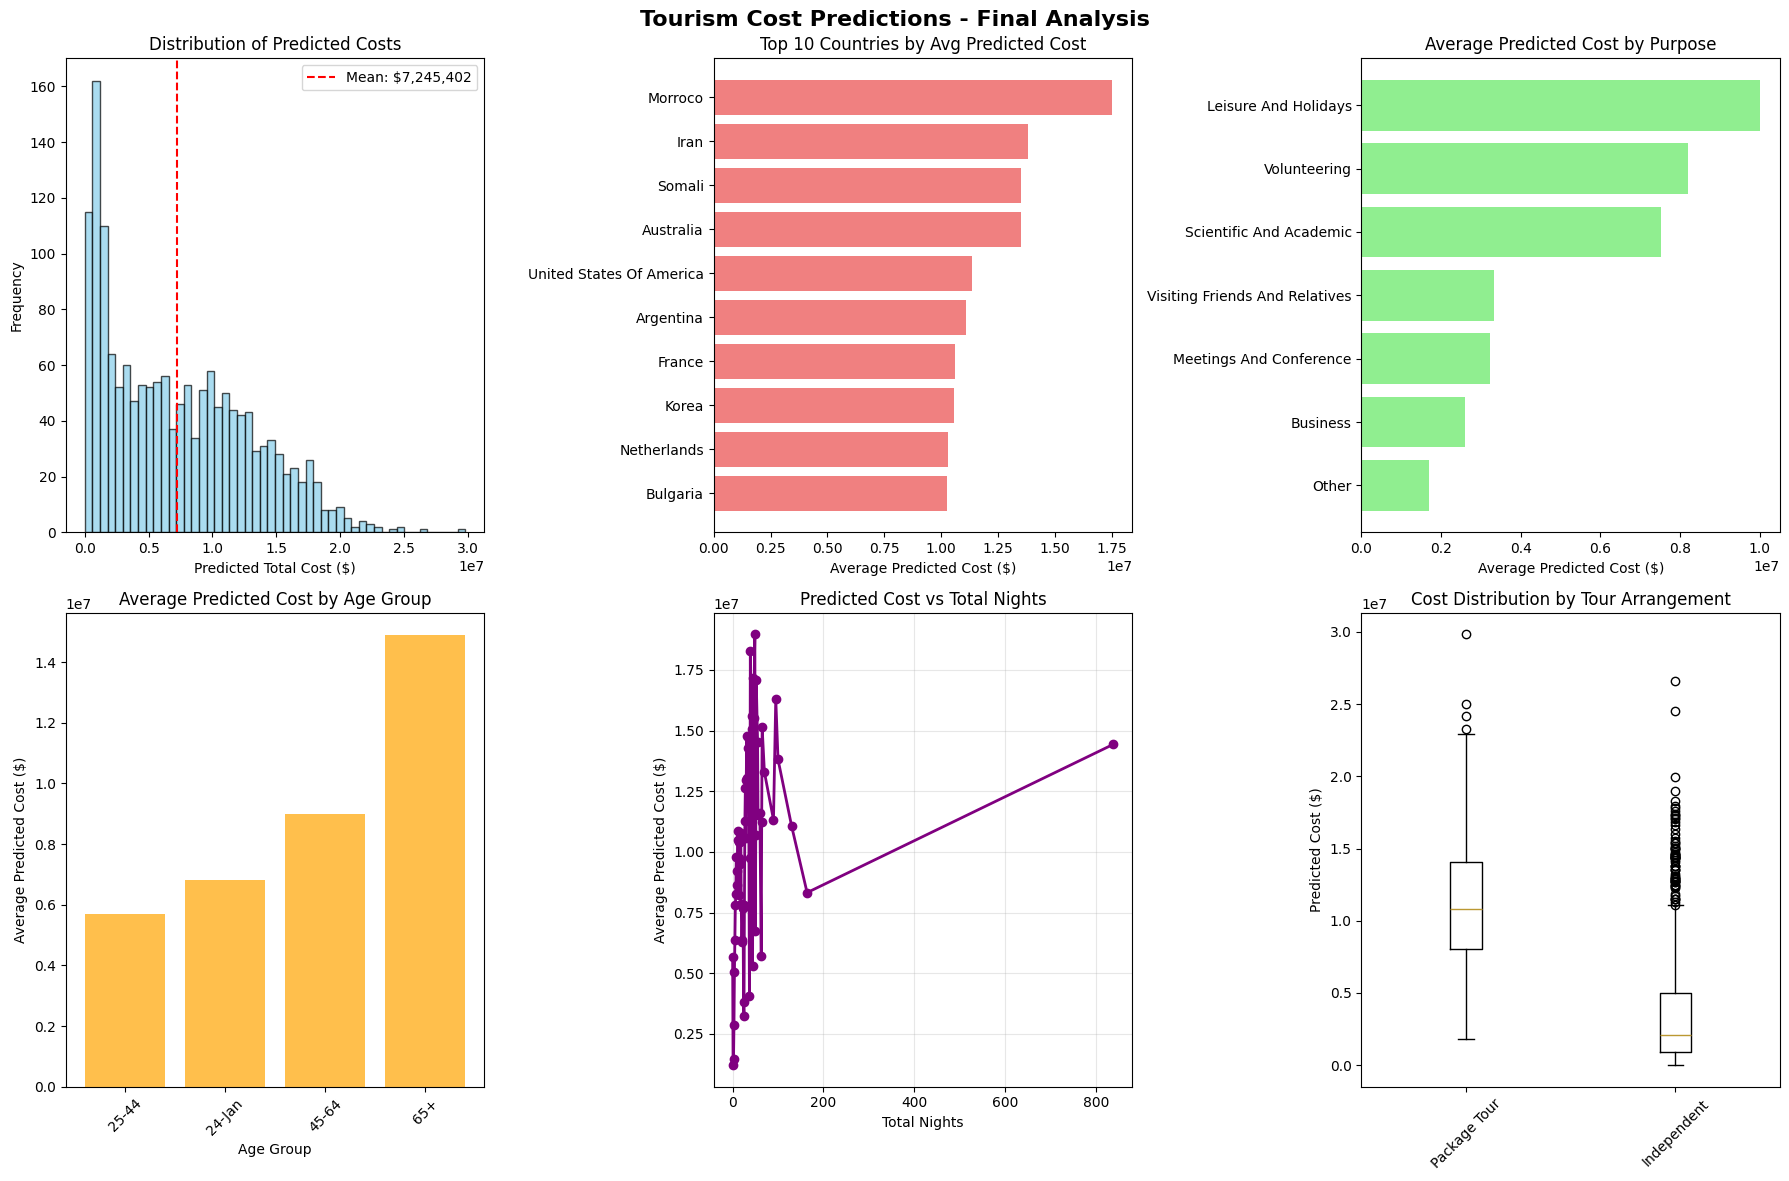

Creating interactive visualizations...



COMPETITION SUBMISSION READY!
File: c:\Users\user\Downloads\college_stuff\data analytics\final_tourism_predictions.csv
Total predictions: 1601
Model used: Gradient Boosting


In [29]:
def run_competition_predictions():
    print("TOURISM COST PREDICTION COMPETITION")
    print("="*60)
    print("Generating predictions for Tanzania tourism expenditure dataset")
    
    if ml_results is None:
        print("ML models not trained yet. Please run the ML analysis first.")
        return None
    
    if test_df is None:
        print("Test data not loaded. Please check data loading.")
        return None
    
    print(f"Training data: {len(ml_results['feature_data'])} samples")
    print(f"Test data: {len(test_df)} samples to predict")
    print(f"Trained models available: {list(ml_results['supervised_models'].keys())}")
    
    model_performance = ml_results['model_results']
    best_model = max(model_performance.keys(), key=lambda x: model_performance[x]['R2'])
    
    print(f"\nMODEL PERFORMANCE COMPARISON:")
    for model_name, metrics in model_performance.items():
        marker = "BEST" if model_name == best_model else "    "
        print(f"{marker} {model_name}: R² = {metrics['R2']:.4f}, RMSE = ${metrics['RMSE']:,.2f}")
    
    print(f"\nSelected model: {best_model}")
    submission_df, test_engineered = predict_test_costs_final(ml_results, test_df, best_model)
    display_predictions_table(submission_df, num_rows=25)
    analyze_final_predictions(submission_df, test_engineered)
    submission_path = save_final_submission(submission_df)
    create_final_prediction_plots(submission_df, test_engineered)
    
    print(f"\nCOMPETITION SUBMISSION READY!")
    print(f"File: {submission_path}")
    print(f"Total predictions: {len(submission_df)}")
    print(f"Model used: {best_model}")
    
    return {
        'submission_df': submission_df,
        'test_data': test_engineered,
        'model_used': best_model,
        'file_path': submission_path
    }

def analyze_final_predictions(submission_df, test_data):
    print(f"\nPREDICTION ANALYSIS BY TOURIST CHARACTERISTICS")
    print("="*55)
    analysis_df = test_data.merge(submission_df, on='ID')
    
    print(f"\nTOP 10 COUNTRIES BY AVERAGE PREDICTED COST:")
    country_stats = analysis_df.groupby('country')['total_cost'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)
    for i, (country, stats) in enumerate(country_stats.head(10).iterrows(), 1):
        std_val = stats['std'] if not pd.isna(stats['std']) else 0
        print(f"{i:2d}. {country.upper():<20} Avg: ${stats['mean']:>8,.0f} | Count: {int(stats['count']):>3d} | Std: ${std_val:>8,.0f}")
    
    print(f"\nAVERAGE PREDICTED COST BY TRAVEL PURPOSE:")
    purpose_stats = analysis_df.groupby('purpose')['total_cost'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for purpose, stats in purpose_stats.iterrows():
        print(f"   {purpose.title():<30} Avg: ${stats['mean']:>8,.0f} | Count: {int(stats['count']):>3d}")
    
    print(f"\nAVERAGE PREDICTED COST BY AGE GROUP:")
    age_stats = analysis_df.groupby('age_group')['total_cost'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for age, stats in age_stats.iterrows():
        print(f"   {age:<15} Avg: ${stats['mean']:>8,.0f} | Count: {int(stats['count']):>3d}")
    
    print(f"\nTOP 5 ACTIVITIES BY AVERAGE PREDICTED COST:")
    activity_stats = analysis_df.groupby('main_activity')['total_cost'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for i, (activity, stats) in enumerate(activity_stats.head(5).iterrows(), 1):
        print(f"{i}. {activity.title():<25} Avg: ${stats['mean']:>8,.0f} | Count: {int(stats['count']):>3d}")

def create_final_prediction_plots(submission_df, test_data):
    print(f"\nCreating final prediction visualizations...")
    plot_data = test_data.merge(submission_df, on='ID')
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Tourism Cost Predictions - Final Analysis', fontsize=16, fontweight='bold')
    
    axes[0,0].hist(plot_data['total_cost'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Predicted Costs')
    axes[0,0].set_xlabel('Predicted Total Cost ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(plot_data['total_cost'].mean(), color='red', linestyle='--', label=f"Mean: ${plot_data['total_cost'].mean():,.0f}")
    axes[0,0].legend()
    
    top_countries = plot_data.groupby('country')['total_cost'].mean().sort_values(ascending=True).tail(10)
    axes[0,1].barh(range(len(top_countries)), top_countries.values, color='lightcoral')
    axes[0,1].set_yticks(range(len(top_countries)))
    axes[0,1].set_yticklabels([c.title() for c in top_countries.index])
    axes[0,1].set_title('Top 10 Countries by Avg Predicted Cost')
    axes[0,1].set_xlabel('Average Predicted Cost ($)')
    
    purpose_costs = plot_data.groupby('purpose')['total_cost'].mean().sort_values(ascending=True)
    axes[0,2].barh(range(len(purpose_costs)), purpose_costs.values, color='lightgreen')
    axes[0,2].set_yticks(range(len(purpose_costs)))
    axes[0,2].set_yticklabels([p.title() for p in purpose_costs.index])
    axes[0,2].set_title('Average Predicted Cost by Purpose')
    axes[0,2].set_xlabel('Average Predicted Cost ($)')
    
    age_costs = plot_data.groupby('age_group')['total_cost'].mean().sort_values()
    axes[1,0].bar(age_costs.index, age_costs.values, color='orange', alpha=0.7)
    axes[1,0].set_title('Average Predicted Cost by Age Group')
    axes[1,0].set_xlabel('Age Group')
    axes[1,0].set_ylabel('Average Predicted Cost ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    plot_data['total_nights'] = plot_data['night_mainland'] + plot_data['night_zanzibar']
    nights_cost = plot_data.groupby('total_nights')['total_cost'].mean()
    axes[1,1].plot(nights_cost.index, nights_cost.values, marker='o', color='purple', linewidth=2)
    axes[1,1].set_title('Predicted Cost vs Total Nights')
    axes[1,1].set_xlabel('Total Nights')
    axes[1,1].set_ylabel('Average Predicted Cost ($)')
    axes[1,1].grid(True, alpha=0.3)
    
    tour_data = [plot_data[plot_data['tour_arrangement'] == arr]['total_cost'] for arr in plot_data['tour_arrangement'].unique()]
    tour_labels = [arr.title() for arr in plot_data['tour_arrangement'].unique()]
    axes[1,2].boxplot(tour_data, labels=tour_labels)
    axes[1,2].set_title('Cost Distribution by Tour Arrangement')
    axes[1,2].set_ylabel('Predicted Cost ($)')
    axes[1,2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Creating interactive visualizations...")
    fig1 = px.histogram(plot_data, x='total_cost', nbins=50, 
                       title='Distribution of Predicted Tourism Costs')
    fig1.update_layout(xaxis_title='Predicted Total Cost ($)', yaxis_title='Count')
    fig1.show()
    
    country_summary = plot_data.groupby('country').agg({
        'total_cost': ['mean', 'count']
    }).round(2)
    country_summary.columns = ['avg_cost', 'count']
    country_summary = country_summary.reset_index()
    
    fig2 = px.scatter(country_summary, x='count', y='avg_cost', 
                     hover_data=['country'], size='count',
                     title='Countries: Predicted Cost vs Number of Tourists')
    fig2.update_layout(xaxis_title='Number of Tourists', yaxis_title='Average Predicted Cost ($)')
    fig2.show()

competition_results = run_competition_predictions()